In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

input_video_path = '/Users/germmartinez/Desktop/Screen Recording 2021-05-29 at 09.59.22.mov'
output_video_path = 'sample_result_2.avi'
path_objects = '/Users/germmartinez/Desktop/crops'
consecutive_frame = 4

In [2]:
def get_background(file_path):
    cap = cv2.VideoCapture(file_path)
    frame_indices = cap.get(cv2.CAP_PROP_FRAME_COUNT) * np.random.uniform(size=250)
    frames = []
    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        frames.append(frame)
    median_frame = np.median(frames, axis=0).astype(np.uint8)
    return median_frame
    

In [3]:
cap = cv2.VideoCapture(input_video_path)
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
out = cv2.VideoWriter(
    output_video_path,
    cv2.VideoWriter_fourcc(*'DIVX'), 10, 
    (frame_width, frame_height)
)

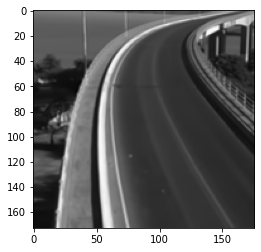

In [4]:
background = get_background(input_video_path)
background = cv2.cvtColor(background, cv2.COLOR_BGR2GRAY)
frame_count = 0

plt.imshow(cv2.cvtColor(background, cv2.COLOR_BGR2RGB))
plt.show()

In [5]:
while (cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:
        frame_count += 1
        orig_frame = frame.copy()
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        if frame_count % consecutive_frame == 0 or frame_count == 1:
            frame_diff_list = []
        frame_diff = cv2.absdiff(gray, background)
        ret, thres = cv2.threshold(frame_diff, 50, 255, cv2.THRESH_BINARY)
        dilate_frame = cv2.dilate(thres, None, iterations=2)
        frame_diff_list.append(dilate_frame)
        if len(frame_diff_list) == consecutive_frame:
            sum_frames = sum(frame_diff_list)
            contours, hierarchy = cv2.findContours(sum_frames, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            for i, cnt in enumerate(contours):
                cv2.drawContours(frame, contours, i, (0, 0, 255), 3)
            i = 1
            for contour in contours:
                if cv2.contourArea(contour) < 500:
                    continue
                (x, y, w, h) = cv2.boundingRect(contour)
                cv2.rectangle(orig_frame, (x, y), (x+w, y+h), (0, 255, 0), 2)    
                new_img=orig_frame[y:y+h,x:x+w]
                sample_img = orig_frame
                success = cv2.imwrite(f"{path_objects}/object_{i}_{frame_count}.png", new_img)
                if not success:
                    raise Exception("crop fails")
                
                i+=1
            cv2.imshow('Detected Objects', orig_frame)
            out.write(orig_frame) 
    else:
        break

cap.release()
cv2.destroyAllWindows()

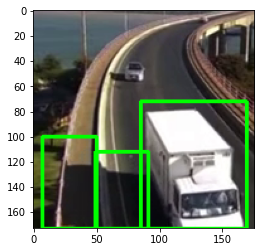

In [6]:
plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))

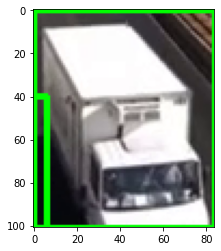

In [7]:
plt.imshow(cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB))